In [4]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [5]:
df =pd.read_csv("dataset_file_directory.csv")


In [6]:
p16_dataset =df[df['Participant']== 'P16']
p16_datasets =p16_dataset[~p16_dataset['Label'].isin([ 'dysregulated','no','request'])]

In [7]:
classess=p16_datasets['Label'].value_counts()

In [8]:
classess

selftalk      354
frustrated    162
delighted     139
social         59
Name: Label, dtype: int64

In [9]:
p16_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 6310 to 7076
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     714 non-null    object
 1   Participant  714 non-null    object
 2   Label        714 non-null    object
dtypes: object(3)
memory usage: 22.3+ KB


In [10]:
# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

In [11]:
def extract_audio_features(dataset):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                stft = librosa.stft(audio_data)
                fft_features = np.abs(stft)
                rmse = librosa.feature.rms(y=audio_data)
                
                fft_features_db = librosa.amplitude_to_db(fft_features, ref=np.max)

            # Calculate the mean of FFT features
                fft_features_mean = np.mean(fft_features_db, axis=1)
                rmse_mean = np.mean(rmse)
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                # Combine the extracted features into a single vector
                combined_mmcs=np.hstack((mfccs_mean,mel_spectrogram_mean,chroma_mean,spectral_contrast_mean))
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, mel_spectrogram_mean, fft_features_mean, rmse_mean))
                mf_mel=np.hstack((mfccs_mean,mel_spectrogram_mean))
                mf_co=np.hstack((mfccs_mean,chroma_mean))
                mf_ch=np.hstack((mfccs_mean,spectral_contrast_mean))
                # Append the extracted features and label to the lists
                mf_ch_list.append(mf_mel)
                mf_co_list.append(mf_ch)
                mf_mel_list.append(mf_co)
                mfcc_fe.append(mfccs_mean)
                rmse_fe.append(rmse_mean)
                chroma_fe.append(chroma_mean)
                spectral_constrast_fe.append(spectral_contrast_mean)
                mel_spectrogram_fe.append(mel_spectrogram_mean)
                fft_fe.append(fft_features_mean)
                combined_4.append(combined_mmcs)
                combined_fe.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [12]:
mfcc_fe=[]
rmse_fe=[]
chroma_fe=[]
spectral_constrast_fe=[]
mel_spectrogram_fe=[]
fft_fe=[]

#fusion of mfcc+mel,fusion of mfcc + contrast,mfcc+chroma
mf_ch_list=[]
mf_co_list=[]
mf_mel_list=[]
combined_4=[]
labels_list=[]
combined_fe=[]
extract_audio_features(p16_datasets)


Related audio files not found count: 0


0

In [14]:
X_mfcc_fe  = np.array(mfcc_fe)
X_rmse_fe  = np.array(rmse_fe)
X_chroma_fe  = np.array(chroma_fe)
X_spectral_constrast_fe= np.array(spectral_constrast_fe)
X_mel_spectrogram_fe= np.array(mel_spectrogram_fe)
X_fft_fe= np.array(fft_fe)

X_mf_ch=np.array(mf_ch_list)
X_mf_co=np.array(mf_co_list)
X_mf_mel=np.array(mf_mel_list)
X_combined=np.array(combined_4)

y=np.array(labels_list)

In [15]:
X_mel_spectrogram_fe.shape

(714, 13)

In [16]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train_mfccs, X_test_mfccs, y_train1, y_test1 = train_test_split(X_mfcc_fe, y_encoded, test_size=0.2, random_state=42)
X_train_chroma, X_test_chroma, _, _ = train_test_split(X_chroma_fe, y_encoded, test_size=0.2, random_state=42)
X_train_spectral_contrast, X_test_spectral_contrast, _, _ = train_test_split(X_spectral_constrast_fe, y_encoded, test_size=0.2, random_state=42)
X_train_mel_spectrogram, X_test_mel_spectrogram, _, _ = train_test_split(X_mel_spectrogram_fe, y_encoded, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(X_fft_fe, y_encoded, test_size=0.2, random_state=42)
X_train_rmse, X_test_rmse, _, _ = train_test_split(X_rmse_fe, y_encoded, test_size=0.2, random_state=42)

X_mf_ch_train, X_mf_ch_test, _,_ = train_test_split(X_mf_ch, y_encoded, test_size=0.2, random_state=42)
X_mf_co_train, X_mf_co_test, _, _ = train_test_split(X_mf_co, y_encoded, test_size=0.2, random_state=42)
X_mf_mel_train, X_mf_mel_test, _, _ = train_test_split(X_mf_mel, y_encoded, test_size=0.2, random_state=42)
X_combined_train, X_combined_test, _, _ = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)



In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
def cnn_model(X_train,y_train,X_test,y_test):
    n_classes=p16_datasets['Label'].nunique()
    model = models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(n_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, 
                   validation_split=0.2, 
                    batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accuracy_stack.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")
    
    return model


def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape, )),  # Reshape for 1D convolution

        # Convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.Conv1D(256, 3, activation='relu', padding='same'),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
accuracy_stack=[]

In [15]:

cnn_model(X_train_mfccs,y_train1,X_test_mfccs,y_test1)

Epoch 1/50
11/11 [==============================] - 1s 50ms/step - loss: 3.3473 - accuracy: 0.3399 - val_loss: 1.1932 - val_accuracy: 0.5478
Epoch 2/50
11/11 [==============================] - 0s 14ms/step - loss: 1.3700 - accuracy: 0.4232 - val_loss: 1.1585 - val_accuracy: 0.5478
Epoch 3/50
11/11 [==============================] - 0s 14ms/step - loss: 1.2295 - accuracy: 0.4386 - val_loss: 1.1821 - val_accuracy: 0.5652
Epoch 4/50
11/11 [==============================] - 0s 14ms/step - loss: 1.1923 - accuracy: 0.4846 - val_loss: 1.0303 - val_accuracy: 0.5391
Epoch 5/50
11/11 [==============================] - 0s 14ms/step - loss: 1.1489 - accuracy: 0.5044 - val_loss: 1.0146 - val_accuracy: 0.5652
Epoch 6/50
11/11 [==============================] - 0s 16ms/step - loss: 1.1159 - accuracy: 0.5482 - val_loss: 1.0129 - val_accuracy: 0.6696
Epoch 7/50
11/11 [==============================] - 0s 16ms/step - loss: 1.0756 - accuracy: 0.5504 - val_loss: 0.9470 - val_accuracy: 0.7130
Epoch 8/50
11

In [16]:
cnn_model(X_train_chroma,y_train1,X_test_chroma,y_test1)

Epoch 1/50
11/11 [==============================] - 1s 42ms/step - loss: 1.3516 - accuracy: 0.3860 - val_loss: 1.2432 - val_accuracy: 0.5391
Epoch 2/50
11/11 [==============================] - 0s 11ms/step - loss: 1.2177 - accuracy: 0.5022 - val_loss: 1.1703 - val_accuracy: 0.5391
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 1.1924 - accuracy: 0.5000 - val_loss: 1.1655 - val_accuracy: 0.5391
Epoch 4/50
11/11 [==============================] - 0s 11ms/step - loss: 1.2057 - accuracy: 0.5044 - val_loss: 1.1582 - val_accuracy: 0.5391
Epoch 5/50
11/11 [==============================] - 0s 13ms/step - loss: 1.1877 - accuracy: 0.5044 - val_loss: 1.1472 - val_accuracy: 0.5391
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 1.2139 - accuracy: 0.5044 - val_loss: 1.1719 - val_accuracy: 0.5391
Epoch 7/50
11/11 [==============================] - 0s 11ms/step - loss: 1.1773 - accuracy: 0.5044 - val_loss: 1.1544 - val_accuracy: 0.5391
Epoch 8/50
11

In [17]:
cnn_model(X_train_mel_spectrogram,y_train1,X_test_mel_spectrogram,y_test1)

Epoch 1/50
11/11 [==============================] - 1s 43ms/step - loss: 1.4664 - accuracy: 0.3860 - val_loss: 1.2125 - val_accuracy: 0.6348
Epoch 2/50
11/11 [==============================] - 0s 12ms/step - loss: 1.2896 - accuracy: 0.5680 - val_loss: 1.0996 - val_accuracy: 0.6957
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 1.2088 - accuracy: 0.6184 - val_loss: 1.0781 - val_accuracy: 0.6957
Epoch 4/50
11/11 [==============================] - 0s 11ms/step - loss: 1.1202 - accuracy: 0.6469 - val_loss: 1.0013 - val_accuracy: 0.6957
Epoch 5/50
11/11 [==============================] - 0s 11ms/step - loss: 1.0707 - accuracy: 0.6469 - val_loss: 0.8818 - val_accuracy: 0.7043
Epoch 6/50
11/11 [==============================] - 0s 13ms/step - loss: 1.0075 - accuracy: 0.6535 - val_loss: 0.8583 - val_accuracy: 0.7130
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.9708 - accuracy: 0.6645 - val_loss: 0.7976 - val_accuracy: 0.6957
Epoch 8/50
11/

In [18]:

cnn_model(X_train_fft, y_train1, X_test_fft, y_test1)


Epoch 1/50
11/11 [==============================] - 2s 144ms/step - loss: 18.4101 - accuracy: 0.3487 - val_loss: 1.1838 - val_accuracy: 0.5391
Epoch 2/50
11/11 [==============================] - 1s 122ms/step - loss: 1.3679 - accuracy: 0.3772 - val_loss: 1.1913 - val_accuracy: 0.5391
Epoch 3/50
11/11 [==============================] - 1s 121ms/step - loss: 1.2929 - accuracy: 0.4759 - val_loss: 1.3347 - val_accuracy: 0.5391
Epoch 4/50
11/11 [==============================] - 1s 120ms/step - loss: 1.3504 - accuracy: 0.4474 - val_loss: 1.2093 - val_accuracy: 0.5391
Epoch 5/50
11/11 [==============================] - 1s 119ms/step - loss: 1.3561 - accuracy: 0.4737 - val_loss: 1.2181 - val_accuracy: 0.5391
Epoch 6/50
11/11 [==============================] - 1s 119ms/step - loss: 1.2758 - accuracy: 0.4605 - val_loss: 1.2231 - val_accuracy: 0.5391
Epoch 7/50
11/11 [==============================] - 1s 116ms/step - loss: 1.2596 - accuracy: 0.4912 - val_loss: 1.1615 - val_accuracy: 0.5391
Epoch

In [19]:
X_train_rmse.shape


(571,)

In [20]:

model2=create_cnn_model(1,5)
history = model2.fit(X_train_rmse, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model2.evaluate(X_test_rmse, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
11/11 [==============================] - 1s 41ms/step - loss: 1.5714 - accuracy: 0.4649 - val_loss: 1.4631 - val_accuracy: 0.5391
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 1.3766 - accuracy: 0.5044 - val_loss: 1.2280 - val_accuracy: 0.5391
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 1.2750 - accuracy: 0.5044 - val_loss: 1.2220 - val_accuracy: 0.5391
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 1.2556 - accuracy: 0.5044 - val_loss: 1.2048 - val_accuracy: 0.5391
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 1.2584 - accuracy: 0.4868 - val_loss: 1.1976 - val_accuracy: 0.5391
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 1.2389 - accuracy: 0.4978 - val_loss: 1.1947 - val_accuracy: 0.5391
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 1.2592 - accuracy: 0.4934 - val_loss: 1.1948 - val_accuracy: 0.5391
Epoch 8/10
11/1

In [21]:


model1=create_cnn_model(7,5)
history = model1.fit(X_train_spectral_contrast, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model1.evaluate(X_test_spectral_contrast, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
11/11 [==============================] - 1s 44ms/step - loss: 1.6579 - accuracy: 0.3421 - val_loss: 1.2957 - val_accuracy: 0.5391
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 1.3665 - accuracy: 0.4583 - val_loss: 1.2058 - val_accuracy: 0.5391
Epoch 3/10
11/11 [==============================] - 0s 13ms/step - loss: 1.2971 - accuracy: 0.4583 - val_loss: 1.1731 - val_accuracy: 0.5391
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 1.2859 - accuracy: 0.4605 - val_loss: 1.1920 - val_accuracy: 0.5391
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 1.2133 - accuracy: 0.5154 - val_loss: 1.1088 - val_accuracy: 0.5304
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 1.1987 - accuracy: 0.4934 - val_loss: 1.0894 - val_accuracy: 0.5391
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 1.1921 - accuracy: 0.5285 - val_loss: 1.1798 - val_accuracy: 0.5478
Epoch 8/10
11

In [22]:
cnn_model(X_mf_ch_train,y_train1,X_mf_ch_test,y_test1)

Epoch 1/50
11/11 [==============================] - 1s 48ms/step - loss: 3.2292 - accuracy: 0.3838 - val_loss: 1.0885 - val_accuracy: 0.6000
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 1.4095 - accuracy: 0.4386 - val_loss: 0.9922 - val_accuracy: 0.6261
Epoch 3/50
11/11 [==============================] - 0s 16ms/step - loss: 1.1211 - accuracy: 0.5548 - val_loss: 0.9635 - val_accuracy: 0.6609
Epoch 4/50
11/11 [==============================] - 0s 17ms/step - loss: 1.0420 - accuracy: 0.6031 - val_loss: 0.9346 - val_accuracy: 0.6522
Epoch 5/50
11/11 [==============================] - 0s 16ms/step - loss: 1.0014 - accuracy: 0.6184 - val_loss: 0.8045 - val_accuracy: 0.7565
Epoch 6/50
11/11 [==============================] - 0s 17ms/step - loss: 0.9173 - accuracy: 0.6579 - val_loss: 0.8155 - val_accuracy: 0.7478
Epoch 7/50
11/11 [==============================] - 0s 17ms/step - loss: 0.8555 - accuracy: 0.6886 - val_loss: 0.8208 - val_accuracy: 0.6783
Epoch 8/50
11

In [23]:
cnn_model(X_mf_co_train,y_train1,X_mf_co_test,y_test1)

Epoch 1/50
11/11 [==============================] - 1s 48ms/step - loss: 3.3213 - accuracy: 0.3026 - val_loss: 1.2618 - val_accuracy: 0.5391
Epoch 2/50
11/11 [==============================] - 0s 16ms/step - loss: 1.3540 - accuracy: 0.4561 - val_loss: 1.0484 - val_accuracy: 0.5652
Epoch 3/50
11/11 [==============================] - 0s 14ms/step - loss: 1.2558 - accuracy: 0.4890 - val_loss: 1.0908 - val_accuracy: 0.5913
Epoch 4/50
11/11 [==============================] - 0s 16ms/step - loss: 1.0732 - accuracy: 0.5307 - val_loss: 1.0061 - val_accuracy: 0.6174
Epoch 5/50
11/11 [==============================] - 0s 16ms/step - loss: 1.0259 - accuracy: 0.5943 - val_loss: 0.9325 - val_accuracy: 0.6783
Epoch 6/50
11/11 [==============================] - 0s 16ms/step - loss: 1.0142 - accuracy: 0.5746 - val_loss: 0.9241 - val_accuracy: 0.6348
Epoch 7/50
11/11 [==============================] - 0s 16ms/step - loss: 0.9585 - accuracy: 0.6272 - val_loss: 0.9198 - val_accuracy: 0.6957
Epoch 8/50
11

In [24]:
cnn_model(X_mf_mel_train,y_train1,X_mf_mel_test,y_test1)

Epoch 1/50
11/11 [==============================] - 1s 49ms/step - loss: 3.4142 - accuracy: 0.3662 - val_loss: 1.1307 - val_accuracy: 0.5391
Epoch 2/50
11/11 [==============================] - 0s 16ms/step - loss: 1.4217 - accuracy: 0.4189 - val_loss: 1.1625 - val_accuracy: 0.5304
Epoch 3/50
11/11 [==============================] - 0s 16ms/step - loss: 1.2020 - accuracy: 0.4605 - val_loss: 1.0257 - val_accuracy: 0.5391
Epoch 4/50
11/11 [==============================] - 0s 16ms/step - loss: 1.1500 - accuracy: 0.5241 - val_loss: 0.9970 - val_accuracy: 0.6261
Epoch 5/50
11/11 [==============================] - 0s 17ms/step - loss: 1.0636 - accuracy: 0.5482 - val_loss: 0.9806 - val_accuracy: 0.6783
Epoch 6/50
11/11 [==============================] - 0s 16ms/step - loss: 1.0290 - accuracy: 0.5702 - val_loss: 0.8467 - val_accuracy: 0.7130
Epoch 7/50
11/11 [==============================] - 0s 16ms/step - loss: 0.9592 - accuracy: 0.6404 - val_loss: 0.8569 - val_accuracy: 0.7304
Epoch 8/50
11

In [25]:
cnn_model(X_combined_train,y_train1,X_combined_test,y_test1)

Epoch 1/50
11/11 [==============================] - 2s 53ms/step - loss: 2.4781 - accuracy: 0.3882 - val_loss: 1.0145 - val_accuracy: 0.6261
Epoch 2/50
11/11 [==============================] - 0s 18ms/step - loss: 1.2859 - accuracy: 0.4539 - val_loss: 1.0305 - val_accuracy: 0.5826
Epoch 3/50
11/11 [==============================] - 0s 17ms/step - loss: 1.1727 - accuracy: 0.5175 - val_loss: 0.9492 - val_accuracy: 0.6609
Epoch 4/50
11/11 [==============================] - 0s 17ms/step - loss: 1.1259 - accuracy: 0.5504 - val_loss: 0.9085 - val_accuracy: 0.6870
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 1.0493 - accuracy: 0.5833 - val_loss: 0.7714 - val_accuracy: 0.7130
Epoch 6/50
11/11 [==============================] - 0s 20ms/step - loss: 1.0610 - accuracy: 0.6096 - val_loss: 0.8513 - val_accuracy: 0.6957
Epoch 7/50
11/11 [==============================] - 0s 17ms/step - loss: 0.9665 - accuracy: 0.6118 - val_loss: 0.7410 - val_accuracy: 0.7391
Epoch 8/50
11

In [26]:
accuracy_stack

[0.6853147149085999,
 0.4895104765892029,
 0.6503496766090393,
 0.5454545617103577,
 0.4335664212703705,
 0.5314685106277466,
 0.7342657446861267,
 0.7412587404251099,
 0.7132866978645325,
 0.692307710647583]

In [27]:
labels=p16_datasets['Label'].unique()

In [28]:
labels

array(['frustrated', 'social', 'selftalk', 'delighted'], dtype=object)

In [29]:
import time
import matplotlib.pyplot as plt
# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1,7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)



Epoch 1/10
11/11 [==============================] - 1s 63ms/step - loss: 3.0076 - accuracy: 0.3640 - val_loss: 1.1277 - val_accuracy: 0.5391
Epoch 2/10
11/11 [==============================] - 0s 31ms/step - loss: 1.2977 - accuracy: 0.4145 - val_loss: 1.1157 - val_accuracy: 0.5739
Epoch 3/10
11/11 [==============================] - 0s 30ms/step - loss: 1.1817 - accuracy: 0.5110 - val_loss: 1.0591 - val_accuracy: 0.5391
Epoch 4/10
11/11 [==============================] - 0s 29ms/step - loss: 1.1606 - accuracy: 0.5351 - val_loss: 1.0117 - val_accuracy: 0.6174
Epoch 5/10
11/11 [==============================] - 0s 28ms/step - loss: 1.0598 - accuracy: 0.5921 - val_loss: 0.9156 - val_accuracy: 0.8000
Epoch 6/10
11/11 [==============================] - 0s 30ms/step - loss: 0.9397 - accuracy: 0.6404 - val_loss: 0.7573 - val_accuracy: 0.8000
Epoch 7/10
11/11 [==============================] - 0s 30ms/step - loss: 0.8654 - accuracy: 0.6930 - val_loss: 0.7832 - val_accuracy: 0.7652
Epoch 8/10
11

11/11 [==============================] - 0s 13ms/step - loss: 1.2029 - accuracy: 0.5154 - val_loss: 1.1323 - val_accuracy: 0.5391
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 1.1982 - accuracy: 0.5000 - val_loss: 1.0684 - val_accuracy: 0.5391
Epoch 8/10
11/11 [==============================] - 0s 13ms/step - loss: 1.1583 - accuracy: 0.5219 - val_loss: 1.0782 - val_accuracy: 0.5565
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 1.1246 - accuracy: 0.5088 - val_loss: 1.0656 - val_accuracy: 0.5739
Epoch 10/10
5/5 [==============================] - 0s 4ms/step - loss: 1.1122 - accuracy: 0.5455
Epoch 1/10
11/11 [==============================] - 1s 63ms/step - loss: 2.8008 - accuracy: 0.3794 - val_loss: 1.1453 - val_accuracy: 0.6261
Epoch 2/10
11/11 [==============================] - 0s 33ms/step - loss: 1.2671 - accuracy: 0.4452 - val_loss: 1.0098 - val_accuracy: 0.6348
Epoch 3/10
11/11 [==============================] - 0s 33ms/step - l

In [30]:
print(model_accuracies)
print(" ")
print(accuracy_stack)

[0.6713286638259888, 0.4475524425506592, 0.6083915829658508, 0.4335664212703705, 0.4335664212703705, 0.5454545617103577, 0.6853147149085999, 0.6643356680870056, 0.7342657446861267, 0.7202796936035156]
 
[0.6853147149085999, 0.4895104765892029, 0.6503496766090393, 0.5454545617103577, 0.4335664212703705, 0.5314685106277466, 0.7342657446861267, 0.7412587404251099, 0.7132866978645325, 0.692307710647583]


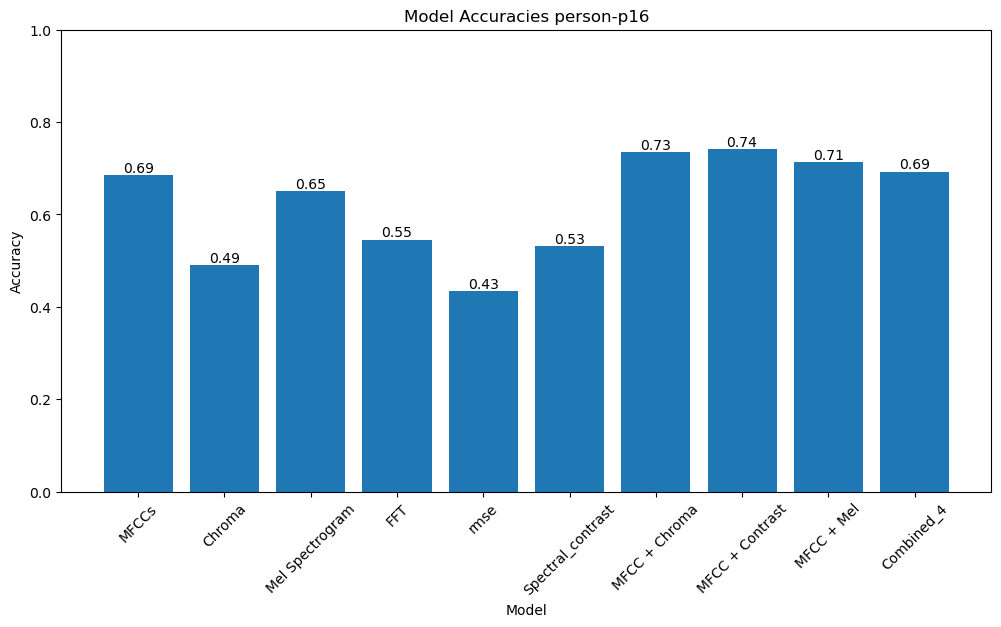

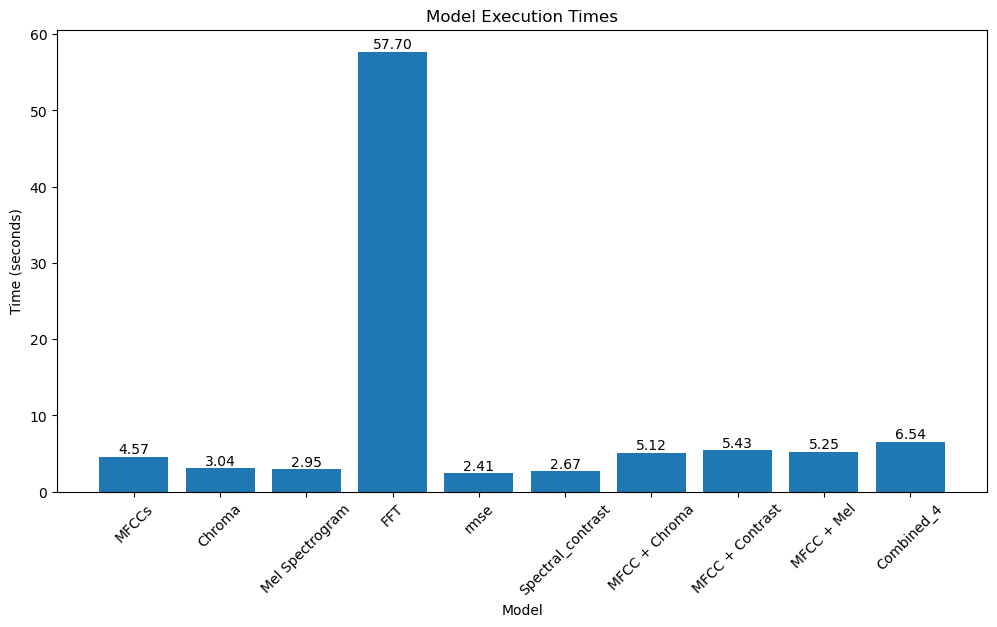

In [35]:

# Plot model accuracies
model_names = [
    "MFCCs", "Chroma", "Mel Spectrogram", "FFT","rmse","Spectral_contrast",
    "MFCC + Chroma", "MFCC + Contrast", "MFCC + Mel","Combined_4"
]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracy_stack)
plt.title("Model Accuracies person-p16")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, accuracy_stack):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
# Plot execution times
plt.figure(figsize=(12, 6))
bar1=plt.bar(model_names, execution_times)
plt.title("Model Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
for bar1, time in zip(bar1, execution_times):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{time:.2f}', ha='center', va='bottom')

plt.show()


In [19]:
model = models.Sequential([
        layers.Reshape((X_train_mfccs.shape[1], 1), input_shape=(X_train_mfccs.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(7, activation='softmax') 
    ])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 50, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 64)            256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 25, 128)           24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 12, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 256)           9